<a href="https://colab.research.google.com/github/JohnTaco93/Foxconn-industrial-AI-Data-Challenge/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#In this kernel the dataset "data01_plc" is processing and merging with the aggregated vibration dataset ("new_agg_vibration").
#Then, with all the data prepared a Light Gradient Boosted Machine algorithm and OLS regression model are trained

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import lightgbm as lgb
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import math

import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [4]:
path_data = "/content/gdrive/My Drive/Foxconn2020-tool-wear/Data-Original/"

In [5]:
data01_plc = pd.read_csv(path_data+'/01-Training Data/01/PLC/plc.csv')

In [6]:
#Changing the time feature from string to datetime
data01_plc['time']=pd.to_datetime(data01_plc.time, format = '%H:%M:%S:%f')
data01_plc.head()

,time,spindle_load,x,y,z,csv_no
0,1900-01-01 11:28:07.127,0.0824,-20.9572,-17.6915,-89.6468,1
1,1900-01-01 11:28:07.137,0.0824,-20.9572,-17.6915,-89.6468,1
2,1900-01-01 11:28:07.147,0.0824,-20.9572,-17.6915,-89.6468,1
3,1900-01-01 11:28:07.157,0.0824,-20.9572,-17.6915,-89.6468,1
4,1900-01-01 11:28:07.167,0.0824,-20.9572,-17.6915,-89.6468,1


In [7]:
#Creating the "RUL" column based on the "time" columns
data01_plc['last_time']=data01_plc['time'].max() 
data01_plc['rul']=data01_plc['last_time']-data01_plc['time']
data01_plc['rul']=data01_plc['rul']/np.timedelta64(1, 'm')
#The "time" and "last_time" columns aren't needed since the "rul" column was created.
data01_plc.drop(['time','last_time'],axis=1,inplace=True) 

In [8]:
data01_plc.head()

,spindle_load,x,y,z,csv_no,rul
0,0.0824,-20.9572,-17.6915,-89.6468,1,300.881100
1,0.0824,-20.9572,-17.6915,-89.6468,1,300.880933
2,0.0824,-20.9572,-17.6915,-89.6468,1,300.880767
3,0.0824,-20.9572,-17.6915,-89.6468,1,300.880600
4,0.0824,-20.9572,-17.6915,-89.6468,1,300.880433


In [9]:
#Creating features
data01_plc['xyz']=np.sqrt(data01_plc['x']**2+data01_plc['y']**2+data01_plc['z']**2)
data01_plc['load_pos']=data01_plc['spindle_load']*data01_plc['xyz']

In [10]:
#Adding vibration-current dataset


In [11]:
#reading the dataset
agg_vibration=pd.read_csv('/content/gdrive/My Drive/Foxconn2020-tool-wear/Notebooks/John/data01_sensor_agg.csv')
agg_vibration.head()

,csv_no,vibration_1_mean,vibration_1_std,vibration_1_max,vibration_2_mean,vibration_2_std,vibration_2_max,vibration_3_mean,vibration_3_std,vibration_3_max,current_mean,current_std,current_max,vibration_1_rms,vibration_2_rms,vibration_3_rms,vibration_1_kurt,vibration_2_kurt,vibration_3_kurt,vibration_1_cest_fct,vibration_2_cest_fct,vibration_3_cest_fct
0,1,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.588040
1,2,0.033860,1.815351,13.055378,-0.009200,1.575724,12.979081,0.012159,2.029509,28.497853,-0.319054,36.355980,59.412173,1.815666,1.575751,2.029545,1.305299,2.013373,0.776188,7.190407,8.236760,14.041500
2,3,0.030849,1.904693,15.540936,-0.012517,1.649458,15.523182,0.013061,1.992761,15.933651,-0.330611,35.652936,58.783423,1.904942,1.649505,1.992803,1.631363,2.612785,0.783387,8.158221,9.410812,7.995598
3,4,0.029016,1.872942,15.947795,-0.013855,1.653137,14.723691,-0.229712,3.973331,29.999038,-0.322389,35.504967,58.372149,1.873166,1.653195,3.979965,1.587242,2.599197,20.588895,8.513819,8.906205,7.537514
4,5,0.030490,1.928085,14.677810,-0.012181,1.715352,16.262056,-0.346211,5.426306,29.999771,-0.316911,35.359442,58.205663,1.928326,1.715395,5.437338,1.686320,2.740558,11.223650,7.611686,9.480066,5.517364


In [12]:
#merging viobration-current with plc data

In [13]:
data01_plc_vibra=pd.merge(data01_plc,agg_vibration,how='left',on='csv_no')

In [14]:
data01_plc_vibra.head()

,spindle_load,x,y,z,csv_no,rul,xyz,load_pos,vibration_1_mean,vibration_1_std,vibration_1_max,vibration_2_mean,vibration_2_std,vibration_2_max,vibration_3_mean,vibration_3_std,vibration_3_max,current_mean,current_std,current_max,vibration_1_rms,vibration_2_rms,vibration_3_rms,vibration_1_kurt,vibration_2_kurt,vibration_3_kurt,vibration_1_cest_fct,vibration_2_cest_fct,vibration_3_cest_fct
0,0.0824,-20.9572,-17.6915,-89.6468,1,300.881100,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
1,0.0824,-20.9572,-17.6915,-89.6468,1,300.880933,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
2,0.0824,-20.9572,-17.6915,-89.6468,1,300.880767,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
3,0.0824,-20.9572,-17.6915,-89.6468,1,300.880600,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804
4,0.0824,-20.9572,-17.6915,-89.6468,1,300.880433,93.748291,7.724859,0.032055,1.257466,10.526876,-0.013657,1.023135,9.440342,-0.008531,1.807261,29.979248,-11.138611,33.050992,68.091055,1.257874,1.023226,1.807281,2.660817,3.224526,19.469639,8.368782,9.226058,16.58804


In [15]:
data01_plc_vibra.tail()

,spindle_load,x,y,z,csv_no,rul,xyz,load_pos,vibration_1_mean,vibration_1_std,vibration_1_max,vibration_2_mean,vibration_2_std,vibration_2_max,vibration_3_mean,vibration_3_std,vibration_3_max,current_mean,current_std,current_max,vibration_1_rms,vibration_2_rms,vibration_3_rms,vibration_1_kurt,vibration_2_kurt,vibration_3_kurt,vibration_1_cest_fct,vibration_2_cest_fct,vibration_3_cest_fct
110022,0.006104,-1.1088,-201.1264,-86.207,48,0.003167,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110023,0.006104,-1.1088,-201.1264,-86.207,48,0.003000,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110024,0.006104,-1.1088,-201.1264,-86.207,48,0.000333,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110025,0.006104,-1.1088,-201.1264,-86.207,48,0.000167,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106
110026,0.006104,-1.1088,-201.1264,-86.207,48,0.000000,218.825741,1.335712,0.041799,0.022109,0.165339,0.003637,0.016938,0.082333,0.021226,0.02818,0.15816,-0.356437,0.07288,-0.014952,0.047285,0.017325,0.035279,0.379656,0.784662,0.264179,3.49661,4.752351,4.483106


In [16]:
#defining dependent variables and independet variable
X=data01_plc_vibra.drop(['rul'],axis=1)
y=data01_plc_vibra.rul.copy() #target

In [17]:
X.drop('csv_no',axis=1,inplace=True)

In [18]:
#Splitting the data in train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
#Transforming the data for  Light Gradient Boosted Machine algorithm
train_data=lgb.Dataset(X_train, y_train)
test_data=lgb.Dataset(X_test, y_test, reference=train_data)

In [20]:
#training the algorithm
params = {'num_leaves': 7,
         'min_data_in_leaf': 250,
         'objective': 'regression',
         'max_depth': 8,
         #'colsample_bytree':0.2,
         'learning_rate': 0.2,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 1,
         'feature_fraction': 1,
         'bagging_seed': 11,
         'random_state': 42,
         'metric': 'mae',
         'verbosity': -1,}
    
model = lgb.train(params,train_data,num_boost_round=10000,valid_sets = [train_data,test_data],verbose_eval=1000,early_stopping_rounds = 300)

Training until validation scores don't improve for 300 rounds.
[1000]	training's l1: 0.0777288	valid_1's l1: 0.080243
[2000]	training's l1: 0.0531579	valid_1's l1: 0.056018
[3000]	training's l1: 0.0422589	valid_1's l1: 0.0451906
[4000]	training's l1: 0.0353919	valid_1's l1: 0.0383664
[5000]	training's l1: 0.0305837	valid_1's l1: 0.0335563
[6000]	training's l1: 0.026947	valid_1's l1: 0.0298449
[7000]	training's l1: 0.0241994	valid_1's l1: 0.0269969
[8000]	training's l1: 0.0219179	valid_1's l1: 0.0245986
[9000]	training's l1: 0.0200156	valid_1's l1: 0.0226241
[10000]	training's l1: 0.0185171	valid_1's l1: 0.0210363
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 0.0185171	valid_1's l1: 0.0210363


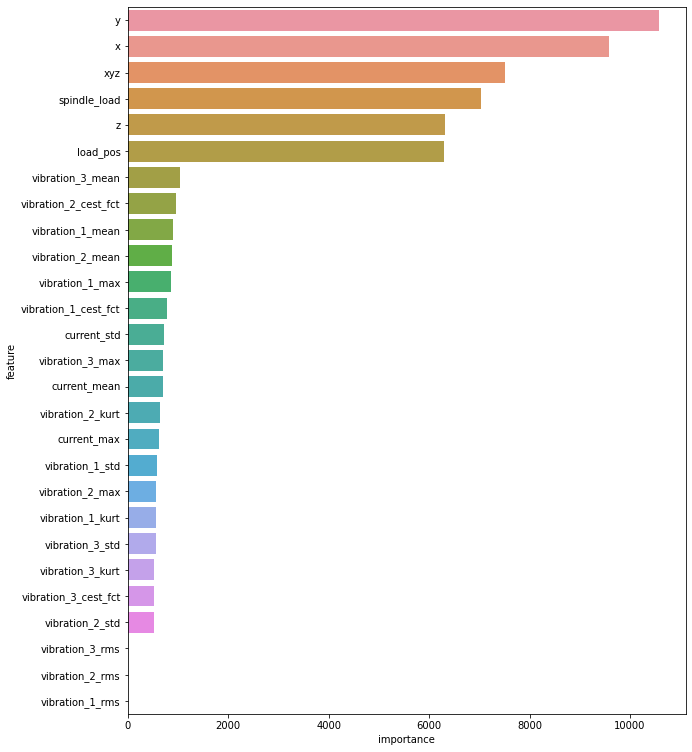

In [21]:
#Feature importance
importance=pd.DataFrame()
importance['feature']=X_train.columns
importance['importance']=model.feature_importance()
f, ax = plt.subplots(figsize=(10, 13))
ax = sns.barplot(x='importance', y='feature', data=importance.sort_values(by='importance',ascending=False))

In [22]:
#OLS regression

In [23]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    rul   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          3.222e+05
Date:                Tue, 18 Aug 2020   Prob (F-statistic):                        0.00
Time:                        17:11:17   Log-Likelihood:                     -4.8054e+05
No. Observations:              110027   AIC:                                  9.611e+05
Df Residuals:                  110000   BIC:                                  9.614e+05
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------